# 利用AdaBoost元算法提高分类性能

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline


def loadSimpData():
    datMat = np.matrix([[1., 2.1], 
                        [2., 1.1],
                        [1.3, 1.],
                        [1., 1.],
                        [2., 1.]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat, classLabels

In [2]:
datMat, classLabels = loadSimpData()

## 基于单层决策树构建弱分类器

In [3]:
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    retArray = np.ones((np.shape(dataMatrix)[0], 1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray


def buildStump(dataArr, classLabels, D):
    dataMatrix = np.mat(dataArr)
    labelMat = np.mat(classLabels).T
    m, n = np.shape(dataMatrix)
    numSteps = 10.0
    bestStump = {}
    bestClasEst = np.mat(np.zeros((m, 1)))
    minError = np.inf
    for i in range(n):
        rangeMin = dataMatrix[:, i].min()
        rangeMax = dataMatrix[:, i].max()
        stepSize = (rangeMax - rangeMin) / numSteps
        for j in range(-1, int(numSteps) + 1):
            for inequal in ['lt', 'gt']:
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = np.mat(np.ones((m, 1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T * errArr
                print("split: dim {:d}, thresh {:.2f}, thresh inequal: {!s}, the weighted error is {:.3f}".
                      format(i, threshVal, inequal, float(weightedError)))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst

In [4]:
D = np.mat(np.ones((5, 1)) / 5)
buildStump(datMat, classLabels, D)

split: dim 0, thresh 0.90, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh inequal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh inequal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.50

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'},
 matrix([[0.2]]),
 array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

## 完整AdaBoost算法的实现

In [5]:
def buildStump0(dataArr, classLabels, D):  # 去掉单层巨册数
    dataMatrix = np.mat(dataArr)
    labelMat = np.mat(classLabels).T
    m, n = np.shape(dataMatrix)
    numSteps = 10.0
    bestStump = {}
    bestClasEst = np.mat(np.zeros((m, 1)))
    minError = np.inf
    for i in range(n):
        rangeMin = dataMatrix[:, i].min()
        rangeMax = dataMatrix[:, i].max()
        stepSize = (rangeMax - rangeMin) / numSteps
        for j in range(-1, int(numSteps) + 1):
            for inequal in ['lt', 'gt']:
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = np.mat(np.ones((m, 1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T * errArr
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst


def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m, 1)) / m)
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump0(dataArr, classLabels, D)
        print("D: ", D.T)
        alpha = float(0.5*np.log((1.0 - error) / max(error, 1e-8)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        print('classEst: ', classEst.T)
        expon = np.multiply(-1*alpha*np.mat(classLabels).T, classEst)
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum()
        aggClassEst += alpha * classEst  # 每个弱分类器的类别估计权值为alpha，之后计算累计类别估计
        print("aggClassEst: ", aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m, 1)))
        errorRate = aggErrors.sum() / m  # 累计类别估计错误率
        print("total errorRate: ", errorRate, "\n")
        if errorRate == 0.0:
            break
    return weakClassArr

In [6]:
classifierArray = adaBoostTrainDS(datMat, classLabels, 9)

D:  [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total errorRate:  0.2 

D:  [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total errorRate:  0.2 

D:  [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total errorRate:  0.0 



In [7]:
classifierArray

[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
 {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]

## 测试算法：基于AdaBoost的分类

In [8]:
def adaClassify(datToClass, classifierArr):
    dataMatrix = np.mat(datToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'], 
                                 classifierArr[i]['ineq'])
        aggClassEst += classEst * classifierArr[i]['alpha']
        print(aggClassEst)
    return np.sign(aggClassEst)

In [9]:
adaClassify([0, 0], classifierArray)

[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]


matrix([[-1.]])

In [10]:
adaClassify([[5, 5], [0, 0]], classifierArray)

[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]


matrix([[ 1.],
        [-1.]])

## 在真实数据集上应用AdaBoost

In [11]:
# 自适应数据加载函数
def loadDataSet(fileName):
    with open(fileName) as f:
        numFeat = len(f.readline().split('\t'))
    dataMat = []
    labelMat = []
    with open(fileName) as fr:
        for line in fr.readlines():
            lineArr = []
            curLine = line.strip().split('\t')
            for i in range(numFeat-1):
                lineArr.append(float(curLine[i]))
            dataMat.append(lineArr)
            labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

In [12]:
datArr, labelArr = loadDataSet('./horseColicTraining2.txt')

In [13]:
def adaBoostTrainDS0(dataArr, classLabels, numIt=40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m, 1)) / m)
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump0(dataArr, classLabels, D)
        alpha = float(0.5*np.log((1.0 - error) / max(error, 1e-8)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        expon = np.multiply(-1*alpha*np.mat(classLabels).T, classEst)
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum()
        aggClassEst += alpha * classEst  # 每个弱分类器的类别估计权值为alpha，之后计算累计类别估计
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m, 1)))
        errorRate = aggErrors.sum() / m  # 累计类别估计错误率
        print("total errorRate: ", errorRate, "\n")
        if errorRate == 0.0:
            break
    return weakClassArr

In [14]:
classifierArray = adaBoostTrainDS0(datArr, labelArr, 50)

total errorRate:  0.2842809364548495 

total errorRate:  0.2842809364548495 

total errorRate:  0.24749163879598662 

total errorRate:  0.24749163879598662 

total errorRate:  0.25418060200668896 

total errorRate:  0.2408026755852843 

total errorRate:  0.2408026755852843 

total errorRate:  0.22073578595317725 

total errorRate:  0.24749163879598662 

total errorRate:  0.23076923076923078 

total errorRate:  0.2408026755852843 

total errorRate:  0.2140468227424749 

total errorRate:  0.22742474916387959 

total errorRate:  0.21739130434782608 

total errorRate:  0.22073578595317725 

total errorRate:  0.21739130434782608 

total errorRate:  0.22408026755852842 

total errorRate:  0.22408026755852842 

total errorRate:  0.23076923076923078 

total errorRate:  0.22408026755852842 

total errorRate:  0.2140468227424749 

total errorRate:  0.20735785953177258 

total errorRate:  0.22408026755852842 

total errorRate:  0.22408026755852842 

total errorRate:  0.2140468227424749 

total er

In [15]:
def adaClassify0(datToClass, classifierArr):
    dataMatrix = np.mat(datToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'], 
                                 classifierArr[i]['ineq'])
        aggClassEst += classEst * classifierArr[i]['alpha']
    return np.sign(aggClassEst)

In [16]:
testArr, testLabelArr = loadDataSet('./horseColicTest2.txt')
prediction10 = adaClassify0(testArr, classifierArray)

In [17]:
errArr = np.mat(np.ones((67, 1)))
errArr[prediction10 != np.mat(testLabelArr).T].sum()

14.0

In [18]:
14 / 67

0.208955223880597

## 非均衡分类问题

### ROC曲线的绘制及AUC计算函数

In [19]:
def adaBoostTrainDS1(dataArr, classLabels, numIt=40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m, 1)) / m)
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump0(dataArr, classLabels, D)
        alpha = float(0.5*np.log((1.0 - error) / max(error, 1e-8)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        expon = np.multiply(-1*alpha*np.mat(classLabels).T, classEst)
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum()
        aggClassEst += alpha * classEst  # 每个弱分类器的类别估计权值为alpha，之后计算累计类别估计
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m, 1)))
        errorRate = aggErrors.sum() / m  # 累计类别估计错误率
        if errorRate == 0.0:
            break
    return weakClassArr, aggClassEst

In [20]:
def plotROC(predStrengths, classLabels):
    cur = (1.0, 1.0)
    ySum = 0.0
    numPosClas = sum(np.array(classLabels) == 1.0)  # 正类样本个数
    yStep = 1 / float(numPosClas)
    xStep = 1 / float(len(classLabels) - numPosClas)
    sortedIndicies = predStrengths.argsort()
    fig = plt.figure()
    plt.clf()
    ax = plt.subplot(111)
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        ax.plot([cur[0], cur[0]-delX], [cur[1], cur[1]-delY], c='b')
        cur = [cur[0] - delX, cur[1] - delY]
    ax.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.axis([0, 1, 0, 1])
    plt.show()
    print("the Area Under the Curve is: ", ySum * xStep)

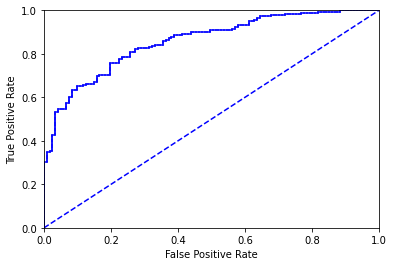

the Area Under the Curve is:  0.8582969635063604


In [21]:
classifierArray, aggClassEst = adaBoostTrainDS1(datArr, labelArr, 10)  # 10个弱分类器
plotROC(aggClassEst.T, labelArr)

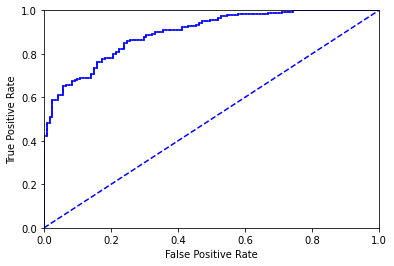

the Area Under the Curve is:  0.8953941870182941


In [22]:
classifierArray, aggClassEst = adaBoostTrainDS1(datArr, labelArr, 50)  # 50个弱分类器
plotROC(aggClassEst.T, labelArr)